<a href="https://colab.research.google.com/github/henrifroese/twitter-poll/blob/master/twitter_pol_notebook_final_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<a href="https://colab.research.google.com/github/hf2000510/twitter_poll/blob/master/twitter_pol_notebook.ipynb" target="_blank">Click here to view the notebook in colab (GitHub doesn't show the graphics!)</a>**

## Predicting the political views of (German & US) Twitter users from their Tweets with Deep Learning

For more explanations, see the model for German politics [here](https://colab.research.google.com/github/henrifroese/twitter-poll/blob/master/twitter_pol_notebook_final_DE.ipynb). This is essentially the same, only for US users.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
!pip install mpld3
import mpld3
mpld3.enable_notebook()

import numpy as np
import pandas as pd
import pickle

import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [ ]:
!pip install TwitterSearch
from TwitterSearch import *
from os import listdir
import importlib.util

spec = importlib.util.spec_from_file_location("keyfile", "/content/drive/My Drive/twitter_pol/keyfile.py")  # twitter api access tokens are stored in the keyfile
keyfile = importlib.util.module_from_spec(spec)
spec.loader.exec_module(keyfile)


The following usernames (grouped by Party) will be used to train/validate the network. All of them are members or confirmed supporters of the party they're grouped with.

In [ ]:
republicans_usernames = ["AustinScottGA08", "boblatta", "brettguthrie", "cathymcmorris", "ConawayTX11",
                         "congbillposey", "CongCulberson", "CongMikeSimpson", "CongPalazzo",
                         "CongressmanHice", "DanaRohrabacher", "DarrellIssa", "daveloebsack",
                         "davereichert", "DavidRouzer", "DrPhilRoe", "farenthold", "GOPLeader",
                         "GreggHarper", "HerreraBeutler", "HurdOnTheHill", "jasoninthehouse",
                         "JeffFortenberry", "Jim_Jordan", "JudgeCarter", "JudgeTedPoe", "repdonyoung",
                         "lisamurkowski", "sendansullivan", "Robert_Aderholt", "RepMoBrooks", "RepByrne",
                         "USRepGaryPalmer", "RepMarthaRoby", "RepMikeRogersAL"

                         
                        
]

democrats_usernames = ["AnthonyBrownMD4", "BennieGThompson", "BettyMcCollum04", "BillPascrell",
                       "BobbyScott", "BradSherman", "chelliepingree", "Clyburn", "CongBoyle",
                       "CongressmanRaja", "CongressmanRuiz", "DonaldNorcross", "DorisMatsui",
                       "EleanorNorton", "FrankPallone", "GerryConnolly", "GKButterfield",
                       "gracenapolitano", "GregoryMeeks", "JacksonLeeTX18", "jahimes",
                       "janschakowsky", "JimLangevin", "JoaquinCastrotx", "RepTerriSewell",
                       "sendougjones"


                       
]

In [ ]:
# from: https://www.kaggle.com/kapastor/democratvsrepublicantweets/version/3?select=TwitterHandles.csv

df_usernames = pd.read_csv("datasets_26920_36624_TwitterHandles.csv")

In [ ]:
democrats_usernames.extend(df_usernames[df_usernames['Party']=="Democrat"].Handle.values.tolist())
republicans_usernames.extend(df_usernames[df_usernames['Party']=="Republican"].Handle.values.tolist())

In [ ]:
import typing
from typing import *

In [ ]:
def tweets_from_usernames(usernames: List[str], party_id: int, num_parties=6) -> List[Any]:
    '''
    usernames: List of twitter handles; have to be from the same party
    party_id: int to assign the tweets to a class (e.g. 1 -> returns [[tweet, 1, 0, 0, 0, 0, 0], ...])
    num_parties: total number of parties

    returns list of lists, with each list of form [tweet, 0, 0, 1, 0, 0] with 1 at party_id (e.g. here = 3) and num_parties 0s and 1s
    '''
    ts = TwitterSearch(
        consumer_key = keyfile.consumer_key,
        consumer_secret = keyfile.consumer_secret,
        access_token = keyfile.access_token,
        access_token_secret = keyfile.access_token_secret
     )

    all_users_combined = []
    one_hot_enc_mask = [0] * num_parties
    one_hot_enc_mask[party_id - 1] = 1

    for username in usernames:
        try:
            tuo = TwitterUserOrder(username)
            tuo.set_include_rts(False)
            tuo.arguments.update({'tweet_mode':'extended'})  # change to Twitter API -> text truncated by default -> set to extended

            for index, tweet in enumerate(ts.search_tweets_iterable(tuo)):
                tweet_content = tweet['full_text']
                all_users_combined.append([tweet_content] + one_hot_enc_mask)
                if index == 99:  # 100 tweets per user
                    break

        except TwitterSearchException as e:
            print(e, username)

    return all_users_combined

In [ ]:
# example
tweets_from_usernames(['c_lindner'], party_id=2, num_parties=3)[2]

['Statt der befristeten Senkung der #Mehrwertsteuer hätte man zum Beispiel auf Dauer den Mittelstandsbauch reduzieren und den #Soli für alle abschaffen sollen. Wir hatten deshalb einen Dreiklang aus 1️⃣Entlasten, 2️⃣ Investieren und 3️⃣ Entfesseln vorgeschlagen.',
 0,
 1,
 0]

## Getting (and serializing) the tweets for each party

In [ ]:
ordered_parties = [democrats_usernames, republicans_usernames]

In [ ]:
tweets_democrats = tweets_from_usernames(usernames=democrats_usernames, party_id=1, num_parties=2)

Error 404: ('Not Found: The URI requested is invalid or', 'the resource requested does not exists') Clyburn
Error 404: ('Not Found: The URI requested is invalid or', 'the resource requested does not exists') CongressmanRuiz
Error 401: ('Unauthorized: Authentication credentials ', ' were missing or incorrect') GregoryMeeks
Error 404: ('Not Found: The URI requested is invalid or', 'the resource requested does not exists') RepJackyRosen
Error 404: ('Not Found: The URI requested is invalid or', 'the resource requested does not exists') RepJackyRosen
Error 404: ('Not Found: The URI requested is invalid or', 'the resource requested does not exists') RepBRochester


In [ ]:
tweets_republicans = tweets_from_usernames(usernames=republicans_usernames, party_id=2, num_parties=2)

Error 401: ('Unauthorized: Authentication credentials ', ' were missing or incorrect') CongCulberson
Error 404: ('Not Found: The URI requested is invalid or', 'the resource requested does not exists') davereichert
Error 404: ('Not Found: The URI requested is invalid or', 'the resource requested does not exists') RepJasonLewis
Error 404: ('Not Found: The URI requested is invalid or', 'the resource requested does not exists') RepMiaLove


In [ ]:
with open("/content/drive/My Drive/twitter_pol/tweets_democrats.pkl", 'wb') as f:
  pickle.dump(tweets_democrats, f)

In [ ]:
with open("/content/drive/My Drive/twitter_pol/tweets_republicans.pkl", 'wb') as f:
  pickle.dump(tweets_republicans, f)

## combining all tweets into a dataframe

In [ ]:
all_tweets = tweets_democrats + tweets_republicans

In [ ]:
df_all_tweets = pd.DataFrame(all_tweets, columns=["text", "democrat", "republican"])

In [ ]:
df_all_tweets.head()

,text,democrat,republican
0,Congrats! https://t.co/DxcQOqfZ11,1,0
1,I’m proud to serve with U.S. Senator @tammyduc...,1,0
2,I'm proud to keep working with @PeteButtigieg ...,1,0
3,We have to do a better job keeping our seniors...,1,0
4,We can’t ask Americans to work if we can’t gua...,1,0


In [ ]:
df_all_tweets.tail()

,text,democrat,republican
9895,Today is #CensusDay!\n\nSmall businesses depen...,0,1
9896,Small businesses across the country are steppi...,0,1
9897,#COVID19 has also revealed the importance of t...,0,1
9898,As we close out #womenshistorymonth amid a cri...,0,1
9899,Are you a small business impacted by #COVID19 ...,0,1


In [ ]:
df_all_tweets.to_pickle("/content/drive/My Drive/twitter_pol/US_all_tweets.pkl")

In [ ]:
df = pd.read_pickle("/content/drive/My Drive/twitter_pol/US_all_tweets.pkl")

BERT input sequences must be at most 512 tokens long. Concat tweets to max 500 each to produce longer tokens that are close to the maximum length.

In [ ]:
with open("/content/drive/My Drive/twitter_pol/tweets_democrats.pkl", 'rb') as f:
  tweets_democrats = pickle.load(f)
with open("/content/drive/My Drive/twitter_pol/tweets_republicans.pkl", 'rb') as f:
  tweets_republicans = pickle.load(f)

In [ ]:
# concat to 500 each
def concat_tweets(tweets_with_one_hot):
    '''
    tweets_with_one_hot: List of form [[tweet, 1, 0, 0], ...]

    returns list of tweets with each sublist having <= 500 tokens
    '''
    concatenated_tweets = []
    one_hot_enc_mask = tweets_with_one_hot[0][1:]
    curr = ""
    for tweet_with_one_hot in tweets_with_one_hot:
      tweet_content = tweet_with_one_hot[0]
      if len(curr) + len(tweet_content.split()) <= 500:
        curr += " " + tweet_content
      else:
        concatenated_tweets.append([curr] + one_hot_enc_mask)
        curr = tweet_content
    if curr:
      concatenated_tweets.append([curr] + one_hot_enc_mask)
    
    return concatenated_tweets

In [ ]:
all_tweets_concat = concat_tweets(tweets_democrats) + concat_tweets(tweets_republicans)
df_all_tweets = pd.DataFrame(all_tweets_concat, columns=["text", "democrat", "republican"])

In [ ]:
df_all_tweets.to_pickle("/content/drive/My Drive/twitter_pol/US_all_tweets_concat.pkl")

# Data Preprocessing

In [ ]:
df = pd.read_pickle("/content/drive/My Drive/twitter_pol/US_all_tweets_concat.pkl")
df

,text,democrat,republican
0,Congrats! https://t.co/DxcQOqfZ11 I’m proud t...,1,0
1,We can’t ask Americans to work if we can’t gua...,1,0
2,Money is not reaching those who need it most. ...,1,0
3,Congratulations to Upper Marlboro native @youn...,1,0
4,"Let's be clear, if we allow states to go bankr...",1,0
...,...,...,...
3693,#COVID19 has devastated the livelihoods of #sm...,0,1
3694,"As of this morning, small business owners can ...",0,1
3695,Looking for a comprehensive small business gui...,0,1
3696,#COVID19 has also revealed the importance of t...,0,1


## cleaning the tweets

In [ ]:
!pip install texthero
import texthero as hero

df["text"] = df["text"].pipe(hero.clean)

In [ ]:
df

,text,democrat,republican
0,Congrats I’m proud to serve with US Senator ...,1,0
1,We can’t ask Americans to work if we can’t gua...,1,0
2,Money is not reaching those who need it most D...,1,0
3,Congratulations to Upper Marlboro native young...,1,0
4,Lets be clear if we allow states to go bankrup...,1,0
...,...,...,...
3693,COVID19 has devastated the livelihoods of smal...,0,1
3694,As of this morning small business owners can a...,0,1
3695,Looking for a comprehensive small business gui...,0,1
3696,COVID19 has also revealed the importance of tr...,0,1


In [ ]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# function to plot the training progress
import matplotlib.pyplot as plt
def my_plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
  ax1.plot(epochs, acc, 'b', label='Training acc')
  ax1.plot(epochs, val_acc, 'g', label='Validation acc')
  ax1.set_title('Training and validation accuracy')
  ax1.legend()

  # ax1.set_figure()

  ax2.plot(epochs, loss, 'b', label='Training loss')
  ax2.plot(epochs, val_loss, 'g', label='Validation loss')
  ax2.set_title('Training and validation loss')
  ax2.legend()

  plt.show()

def my_plot_2(history):
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(acc) + 1)

  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
  ax1.plot(epochs, acc, 'b', label='Training acc')
  ax1.plot(epochs, val_acc, 'g', label='Validation acc')
  ax1.set_title('Training and validation accuracy')
  ax1.legend()

  # ax1.set_figure()

  ax2.plot(epochs, loss, 'b', label='Training loss')
  ax2.plot(epochs, val_loss, 'g', label='Validation loss')
  ax2.set_title('Training and validation loss')
  ax2.legend()

  plt.show()



## Word Cloud

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

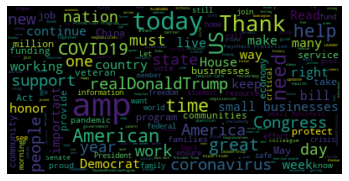

In [ ]:
stopw = set(stopwords.words('german'))
stopw2 = set(stopwords.words('english'))
rep_text = ' '.join([word for word in ' '.join(df[df["republican"]==1].text.values.tolist()).split() if word.lower() not in stopw and word.lower() not in stopw2])

wordcloud = WordCloud(max_font_size=40).generate(rep_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Simple Approach
Here we use the [BERT Embeddings](https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) on the Text to create high-dimensional embeddings of the tweets. Those embeddings are the input for the model. The model first embeds these embeddings into a new 512-dim. embedding. The resulting embeddings are fed into a bidirectional LSTM layer. Finally, a dense softmax layer with 6 nodes is applied to get party probabilities.

This relatively simple approach yields about 70% accuracy. (With a non-bidirectional LSTM layer, training progress is much slower. Different hyperparameters were tried, the ones in use were the best.)

In [ ]:
import tensorflow as tf
from keras.utils import plot_model
tf.__version__

Using TensorFlow backend.


'2.2.0'

In [ ]:
tf.keras.backend.set_floatx("float32")

In [ ]:
train_targets = df[["democrat", "republican"]]
train_targets = train_targets.values

train_inputs = df.text.values

(3698, 2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_inputs)

train_sequences = tokenizer.texts_to_sequences(train_inputs)
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=500, padding="post", truncating="post")

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=10001, output_dim=256, input_length=500, input_shape=(500,)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), input_shape=(500, 256)))
model.add(tf.keras.layers.Dense(2, activation='softmax', input_shape=(128,)))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 256)          2560256   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 2,724,866
Trainable params: 2,724,866
Non-trainable params: 0
_________________________________________________________________


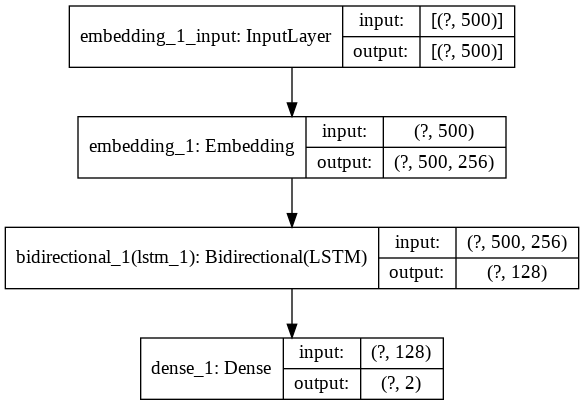

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
opt = tf.keras.optimizers.RMSprop()
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(tf.convert_to_tensor(train_sequences, dtype=tf.float32), train_targets,
                    epochs=3,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/3
93/93 [==============================] - 7s 73ms/step - loss: 0.6001 - acc: 0.6650 - val_loss: 0.3950 - val_acc: 0.8189
Epoch 2/3
93/93 [==============================] - 6s 63ms/step - loss: 0.2116 - acc: 0.9263 - val_loss: 0.2954 - val_acc: 0.8716
Epoch 3/3
93/93 [==============================] - 6s 64ms/step - loss: 0.0789 - acc: 0.9753 - val_loss: 0.3127 - val_acc: 0.8716


In [ ]:
# for storing the model.

import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

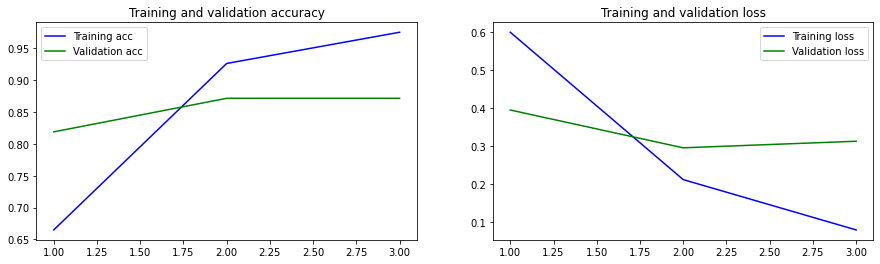

In [ ]:
my_plot(history)

# Advanced Approach: BERT for Sequence Classification
In this approach, the BERT model (and not only the embeddings as in the former approach) is used to classify the tweets. The [cls] special token is fed straight into a final dense softmax layer for classification as suggested in the [BERT paper](https://arxiv.org/abs/1810.04805) (using the full sequence output or the pooled output has not lead to better results).

Performance is around 76-80% after 2-4 epochs.

In [ ]:
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

%tensorflow_version 2.x


!pip install transformers
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert_layer = transformers.TFBertModel.from_pretrained("bert-base-cased")

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    '''
    texts: list of strings, each string one text to be encoded (e.g. ["First tweet text", "Second tweet text", ...])
    tokenizer: a BERT tokenizer (e.g. AutoTokenizer.from_pretrained("bert-base-german-cased"))
    max_len: maximum length of each string (number of words!) in the texts list

    output: tuple of BERT encodings of the input texts: (word_ids, attention_masks, segment_ids)
    '''
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
# example
bert_encode(["Text one", "Text two"], tokenizer, max_len=5)

(array([[    3,  3779,  6634, 26897,     4],
        [    3,  3779,   209,  3761,     4]]), array([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]), array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]))

In [ ]:
train_input = bert_encode(df.text.values, tokenizer, max_len=500)

train_targets = df[["linke", "green", "spd", "fdp", "cdu", "afd"]]
train_targets = train_targets.values

BERT paper suggests
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [ ]:
def build_model(bert_layer, max_len=512, l_rate=2e-5):
    # 3 inputs (as returned by bert_encode): word ids, attention masks, segment ids
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    # bert layer returns two outputs: a sequence output and an already-pooled output (that we don't need for classification)
    sequence_output, pooled_output = bert_layer([input_word_ids, input_mask, segment_ids])
    out = Dense(6, activation='softmax')(sequence_output[:, 0, :])  # very first arg of seq output is [cls]-token that will be used for classification

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=l_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = build_model(bert_layer, max_len=500, l_rate=2e-5)

In [ ]:
model.summary(line_length=150)

Model: "model_9"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_word_ids (InputLayer)                      [(None, 500)]                    0                                                                   
______________________________________________________________________________________________________________________________________________________
input_mask (InputLayer)                          [(None, 500)]                    0                                                                   
______________________________________________________________________________________________________________________________________________________
segment_ids (InputLayer)                         [(None, 500)]               

In [ ]:
train_history = model.fit(
    train_input, train_targets,
    validation_split=0.2,
    epochs=3,
    batch_size=8  # batch size 16+ (as recommended in BERT paper) too expensive for colab
)

1457/1457 [==============================] - 858s 589ms/step - loss: 1.1435 - accuracy: 0.5752 - val_loss: 0.8880 - val_accuracy: 0.6782


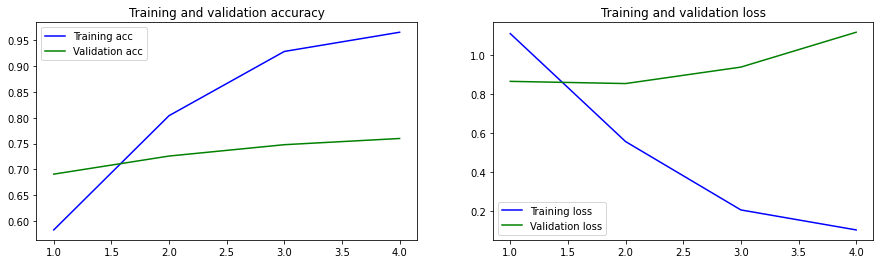

In [ ]:
my_plot_2(train_history)

In [ ]:
tf.keras.models.save_model(model, '/content/drive/My Drive/twitter_pol/my_model.h5py')  # creates a HDF5 file 'my_model.h5'

# Using the BERT Network for predictions

In [ ]:
import tensorflow as tf
from keras import backend as K

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import numpy as np

Using TensorFlow backend.


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/twitter_pol/my_model.h5py', custom_objects=None, compile=True)

In [ ]:
!pip install TwitterSearch
import nltk
nltk.download('stopwords')
import importlib.util

spec = importlib.util.spec_from_file_location("tweets", "/content/drive/My Drive/twitter_pol/tweets.py")
tweets = importlib.util.module_from_spec(spec)
spec.loader.exec_module(tweets)

In [ ]:
def username_to_prediction(username):
  '''
  username: valid twitter username as string (user must not be private)

  returns tuple (username, pred) where pred is 6-dimensional array of softmax output
  '''
  # get and concat (to <= 500 each) and concat up to 100 tweets of the given username
  list_of_tweets = [remove_URL(remove_html(remove_punct(tweet[0]))) for tweet in concat_tweets(tweets_from_usernames([username], party_id=1, num_parties=2))]
  # encode the user's tweets
  network_input = bert_encode(list_of_tweets, tokenizer, max_len=500)
  # get the network's predictions
  preds = model.predict(network_input, verbose=0)
  return username, np.mean(preds, axis=0)

In [ ]:
def plot_prediction(username, user_prediction):
  fig, ax = plt.subplots()
  rects1 = ax.bar(np.arange(len(np.squeeze(user_prediction))),np.squeeze(user_prediction))
  ax.set_xticks(np.arange(len(np.squeeze(user_prediction))))
  ax.set_xticklabels(("linke", "green", "spd", "fdp", "cdu", "afd"))
  ax.set_ylabel('Confidence')
  ax.set_xlabel('Party')
  ax.yaxis.set_label_coords(-0.12,0.5)
  title = "username: " + username
  ax.set_title(title)
  plt.show()

In [ ]:
def username_to_plot(username):
  plot_prediction(*username_to_prediction(username))  

### Showcasing the network:
Of course, none of the accounts shown here were present in training/validation/test data.


"AfD_HD" is the official twitter account of the AfD in Heidelberg.

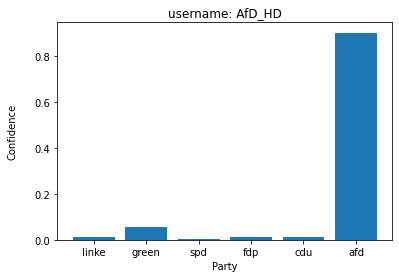

In [ ]:
username_to_plot("AfD_HD")

Malte Kaufmann is chairman of the AfD Heidelberg

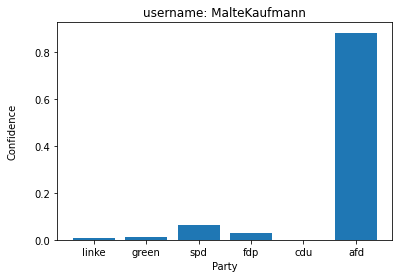

In [ ]:
username_to_plot("MalteKaufmann")

Official twitter account of CDU in Saxony

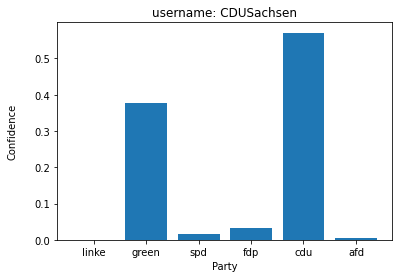

In [ ]:
username_to_plot("CDUSachsen")

Official account of SPD in Hamburg

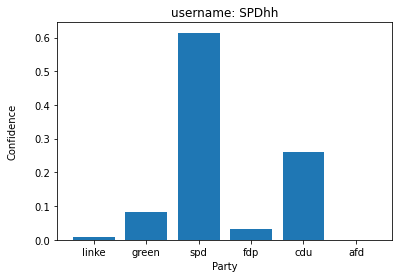

In [ ]:
username_to_plot("SPDhh")

Official account of Green Party


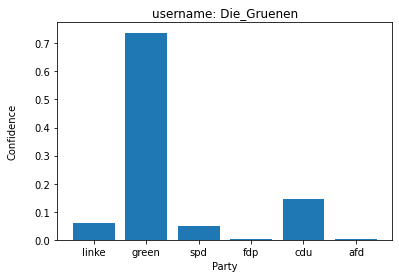

In [ ]:
username_to_plot("Die_Gruenen")

Official account of Linke in the national parliament

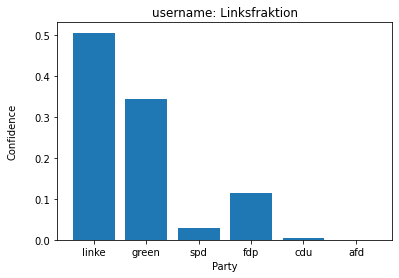

In [ ]:
username_to_plot("Linksfraktion")

Official account of FDP in the national parliament

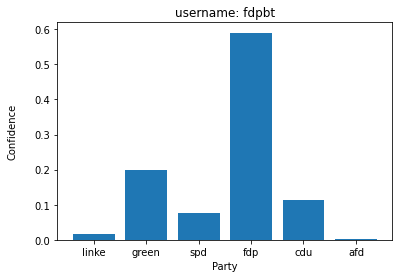

In [ ]:
username_to_plot("fdpbt")